In [9]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Gate compilation given its columns via Householder reflections

In [10]:
import random

from scipy.stats import unitary_group
import numpy as np

from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import PlusState
from qualtran.drawing import show_bloq
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientState
from qualtran.bloqs.state_preparation.state_preparation_via_rotation import StatePreparationViaRotations
from qualtran.bloqs.chemistry.prepare_mps.compile_gate import CompileGateFromColumnsNoPG, CompileGateFromColumns

This bloq compiles a quantum gate $U$ given a list of its columns, which might be incomplete. It uses Householder reflections on states prepared with `StatePreparationViaRotations`.

Refer to https://arxiv.org/abs/1306.3200 for the method used.

## Example of use

Assume one wants to compile a `gate_bitsize` qubit gate $U$ using a rotation precision given by `phase_bitsize`.

In [11]:
def getRandomUnitary (gate_bitsize):
  U = unitary_group.rvs(2**gate_bitsize)
  return U

gate_bitsize = 2
phase_bitsize = 3
U = getRandomUnitary(gate_bitsize)

## Building the Bloq

The parameters the bloq receives are:

  - `phase_bitsize`: number of qubits used to store the rotation angle. This determines the
    accuracy of the results, but increases computational resources.
  - `gate_cols`: tuple that contains the columns of the gate. In each position this tuple has to
    contain the index of the column and the data that it stores, i.e.: ((0, (1j,0)), (1, (0,1))).
  - `uncompute`: defaults to `False`. Wether the compiled gate is $U$ or $U^\dagger$. If true, the
    data in `gate_cols` determines the rows of the matrix, and the vectors will be transposed. That
    is, if one wants to implement $U^\dagger$ the `gate_cols` provided must be the same as in the
    case of $U$. This can also be used if one wants to specify the rows of $U$ instead of the
    columns. In this case take the conjugate of the coefficients.

The data in the array `U` declared previously must be adapted to the correct format. Below is an
example of use together with its bloq decomposition.

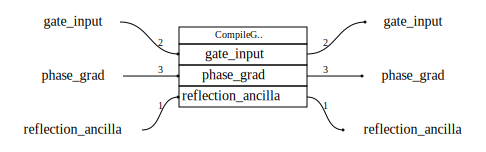

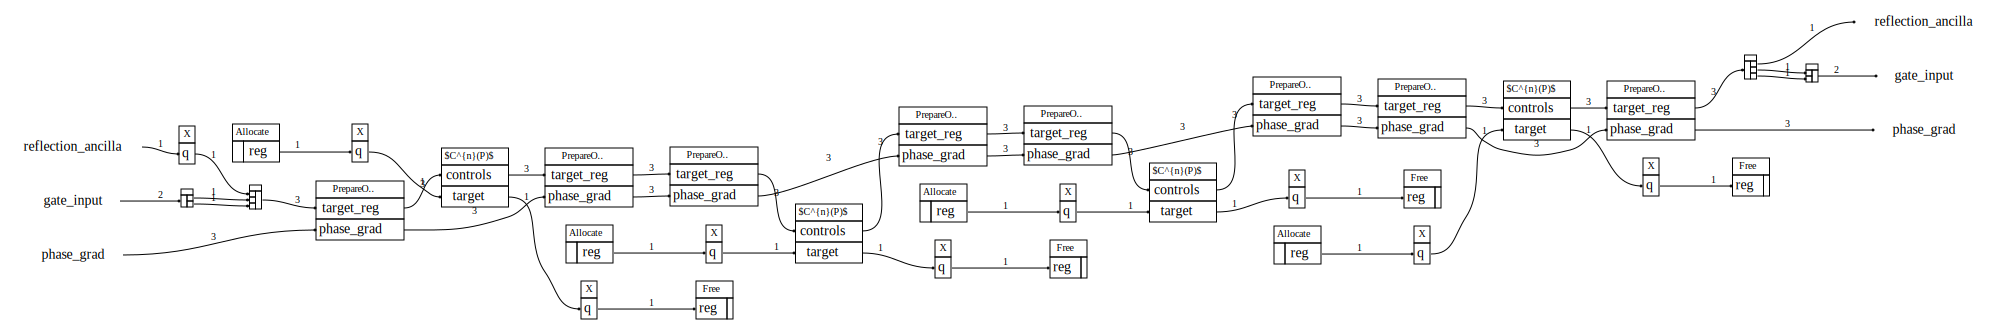

In [12]:
# remember to take the transpose of the gate, as the vectors specify the columns of the matrix
gate_cols = tuple([(i, tuple(c)) for i,c in enumerate(U.T)])
gate_compiler = CompileGateFromColumns(phase_bitsize=phase_bitsize, gate_cols=gate_cols)

show_bloq(gate_compiler)
show_bloq(gate_compiler.decompose_bloq())

For each column it is possible to see the reflection, composed of a prepare bloq, a reflection and
another prepare bloq, which is transposed.

## Using the bloq in a circuit

The gate compilation module offers two classes. The main one, which was used before, is
`CompileGateFromColumns`. This bloq receives the gate input and a phase gradient, which is used to
perform the rotations and left unchanged, so it can be reused if multiple gates are compiled in
order to get the best T-gate count. However, if a single gate is compiled there is the alternative
`CompileGateFromColumnsNoPG`. This gate still uses a phase gradient state but it is obtained
internally, so it does not need to be provided.

In the following sections the latter variant is used, but it is analogous to the former.

Now let us show an example of how to use this bloq in a circuit, together with the tensor
contraction of it to show that it correctly implements the desired gate.

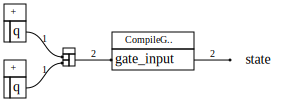

In [13]:
gate_compiler = CompileGateFromColumnsNoPG(phase_bitsize, gate_cols)

bb = BloqBuilder()
state = bb.join(np.array([bb.add(PlusState()), bb.add(PlusState())]))
state = bb.add(gate_compiler, gate_input = state)
circuit = bb.finalize(state=state)

show_bloq(circuit)
result = circuit.tensor_contract()
compiled_gate = gate_compiler.tensor_contract()

And finally a comparison with the correct results.

In [14]:
def c2pol (c):
    # round 0 to eliminate phase
    if abs(c) < 1e-14:
        c = 0
    return f"{abs(c):.3f} ∠ {np.angle(c, deg=True):04.2f}º"

def compare_gate_results (comp, original):
    print("* compiled gate  ||  original gate U (coefficients in polar form):\n")
    for compiled, correct in zip(comp, original):
        print("  ".join([c2pol(c) for c in compiled]) + "    ||    "\
            + "  ".join([c2pol(c) for c in correct]))

correct_result = 0.5*U@np.ones((4,1))
correct_result = correct_result.reshape((-1))

accuracy = abs(np.dot(correct_result.conj(), result))
print(f"* Accuracy of <++|U U_compiled|++>: {accuracy}\n")

print("* Comparison of U|++> (coefficients in polar form):\n")
for i, (compiled, correct) in enumerate(zip(result, correct_result)):
    print(f"  |{i:0{gate_bitsize}b}> result: {c2pol(compiled)}     correct: {c2pol(correct)}")

print("\n")
compare_gate_results(compiled_gate, U)

* Accuracy of <++|U U_compiled|++>: 0.9783634254669262

* Comparison of U|++> (coefficients in polar form):

  |00> result: 0.384 ∠ 64.90º     correct: 0.450 ∠ 82.65º
  |01> result: 0.567 ∠ 142.17º     correct: 0.624 ∠ 143.44º
  |10> result: 0.345 ∠ -162.81º     correct: 0.269 ∠ -161.82º
  |11> result: 0.629 ∠ 34.00º     correct: 0.579 ∠ 39.55º


* compiled gate  ||  original gate U (coefficients in polar form):

0.660 ∠ 94.31º  0.088 ∠ 135.00º  0.279 ∠ 126.54º  0.653 ∠ -22.50º    ||    0.741 ∠ 104.51º  0.090 ∠ 34.83º  0.401 ∠ 133.71º  0.531 ∠ -18.17º
0.177 ∠ 122.04º  0.890 ∠ 158.40º  0.299 ∠ 22.50º  0.271 ∠ 157.50º    ||    0.296 ∠ 125.39º  0.846 ∠ 167.65º  0.344 ∠ 41.39º  0.279 ∠ 160.34º
0.535 ∠ 90.90º  0.183 ∠ -70.07º  0.606 ∠ -110.63º  0.500 ∠ 180.00º    ||    0.571 ∠ 80.28º  0.273 ∠ -83.14º  0.607 ∠ -106.73º  0.481 ∠ 165.43º
0.351 ∠ 59.44º  0.385 ∠ -54.35º  0.675 ∠ 18.43º  0.500 ∠ 90.00º    ||    0.191 ∠ 78.10º  0.449 ∠ -55.62º  0.594 ∠ 28.80º  0.640 ∠ 82.87º


## Partial specification of the gate

As mentioned before, it is possible to specify only some columns of the matrix. Notice below that
only the first and last columns are close to the original operator.

In [15]:
partial_gate_cols = (gate_cols[0], gate_cols[-1])
gate_compiler = CompileGateFromColumnsNoPG(phase_bitsize, partial_gate_cols)
compiled = gate_compiler.tensor_contract()
compare_gate_results(compiled, U)

* compiled gate  ||  original gate U (coefficients in polar form):

0.608 ∠ 96.92º  0.000 ∠ 0.00º  0.000 ∠ 0.00º  0.653 ∠ -22.50º    ||    0.741 ∠ 104.51º  0.090 ∠ 34.83º  0.401 ∠ 133.71º  0.531 ∠ -18.17º
0.306 ∠ 125.26º  0.000 ∠ 0.00º  0.000 ∠ 0.00º  0.271 ∠ 157.50º    ||    0.296 ∠ 125.39º  0.846 ∠ 167.65º  0.344 ∠ 41.39º  0.279 ∠ 160.34º
0.566 ∠ 77.24º  0.000 ∠ 0.00º  0.000 ∠ 0.00º  0.500 ∠ 180.00º    ||    0.571 ∠ 80.28º  0.273 ∠ -83.14º  0.607 ∠ -106.73º  0.481 ∠ 165.43º
0.379 ∠ 82.14º  0.000 ∠ 0.00º  0.000 ∠ 0.00º  0.500 ∠ 90.00º    ||    0.191 ∠ 78.10º  0.449 ∠ -55.62º  0.594 ∠ 28.80º  0.640 ∠ 82.87º


## Using the adjoint

This bloq also implements the adjoint of the compiled gate though the attribute `uncompute`, which
is set to `False` as a default. Note that in this example the class that requires a phase gradient
to be provided,`CompileGateFromColumns` ,is used for no particular reason.

The circuit below uses both the compilation of $U$ and $U^\dagger$, and also a state preparation
gate that acts as $|\psi\rangle = R_{|\psi\rangle}|0\rangle$ and its adjoint. It starts at
$|0\rangle$, prepares a random state $|\psi\rangle$, applies $U$, then $U^\dagger$ and finally
unprepares the same state to leave the register at $|0\rangle$.

$$
    |0\rangle = R_{|\psi\rangle}^\dagger U^\dagger U  R_{|\psi\rangle}|0\rangle
$$

 * Resulting state (coefficients in polar form):
  |00>  1.000 ∠ 0.00º
  |01>  0.000 ∠ 0.00º
  |10>  0.000 ∠ 0.00º
  |11>  0.000 ∠ 0.00º


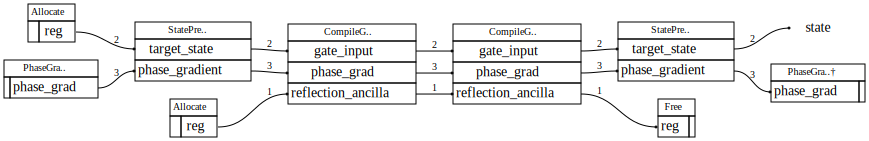

In [17]:
def gen_random_state (state_bitsizes: int):
    state = np.array([random.uniform(-1,1) + random.uniform(-1,1)*1j for _ in range(2**state_bitsizes)])
    return state/np.linalg.norm(state)

random_state = tuple(gen_random_state(gate_bitsize))
gate_comp     = CompileGateFromColumns(phase_bitsize, gate_cols, uncompute=False)
gate_comp_adj = CompileGateFromColumns(phase_bitsize, gate_cols, uncompute=True)
state_prep     = StatePreparationViaRotations(phase_bitsize, random_state, uncompute=False)
state_prep_adj = StatePreparationViaRotations(phase_bitsize, random_state, uncompute=True)

bb = BloqBuilder()
state = bb.allocate(gate_bitsize)
ra = bb.allocate(1)
pg = bb.add(PhaseGradientState(phase_bitsize))
state, pg = bb.add(state_prep, target_state=state, phase_gradient=pg)
state, pg, ra = bb.add(gate_comp, gate_input=state, phase_grad=pg, reflection_ancilla=ra)
state, pg, ra = bb.add(gate_comp_adj, gate_input=state, phase_grad=pg, reflection_ancilla=ra)
state, pg = bb.add(state_prep_adj, target_state=state, phase_gradient=pg)
bb.add(PhaseGradientState(phase_bitsize).adjoint(), phase_grad=pg)
bb.free(ra)
circuit = bb.finalize(state=state)
result = circuit.tensor_contract()

print(f" * Resulting state (coefficients in polar form):")
print("\n".join([f"  |{i:0{gate_bitsize}b}>  {c2pol(c)}" for i, c in enumerate(result)]))
show_bloq(circuit)

## Controlled version

# TODO